In [1]:
import os
import time
import numpy as np
import pypulseq
import scipy.io as sio
from numpy import linalg as la

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from cest_mrf.write_scenario import write_yaml_dict
from cest_mrf.dictionary.generation import generate_mrf_cest_dictionary
from cest_mrf.metrics.dot_product import  dot_prod_matching

import os
import sys

# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.colormaps import b_viridis, b_winter  

from configs import ConfigClinical
from sequences import write_sequence_clinical

import pypulseq as pp

# Specify data folder and output folder

In [2]:
data_f = 'data'
output_f = 'results'

# Write .yaml file and .seq file

In [3]:
# cfg = ConfigParams()
cfg = ConfigClinical().get_config()

# Write the .yaml according to the config.py file (inside cest_mrf folder)
write_yaml_dict(cfg, cfg['yaml_fn'])

b1 = [2, 2, 1.7, 1.5, 1.2, 1.2, 3, 0.5, 3, 1, 2.2, 3.2, 1.5, 0.7, 1.5, 2.2, 2.5, 1.2, 3, 0.2, 1.5, 2.5, 0.7, 4,
        3.2, 3.5, 1.5, 2.7, 0.7, 0.5]

# Write the seq file for a 2d experiment
# for more info about the seq file, check out the pulseq-cest repository (https://pulseq-cest.github.io/)
seq_defs = {}
seq_defs["n_pulses"] = 13  # number of pulses
seq_defs["num_meas"] = len(b1)  # number of repetition
seq_defs["tp"] = 100e-3  # pulse duration [s]
seq_defs["td"] = 100e-3  # interpulse delay [s]
seq_defs["offsets_ppm"] = np.ones(seq_defs["num_meas"]) * 3.0

TR = np.ones(seq_defs["num_meas"]) * 3.5
Tsat = np.ones(seq_defs["num_meas"]) * 2.5

seq_defs["dcsat"] = (seq_defs["tp"]) / (seq_defs["tp"] + seq_defs["td"])  # duty cycle
seq_defs["tsat"] = Tsat  # saturation time [s]
seq_defs["trec"] = TR - seq_defs["tsat"]  # net recovery time [s]
seq_defs["spoiling"] = True

seqid = os.path.splitext(cfg['seq_fn'])[1][1:]
seq_defs['seq_id_string'] = seqid  # unique seq id

# We vary B1 for the dictionary generation
seq_defs['b1'] = b1


# create scanner limits object
lims = pp.Opts(
    max_grad=40,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    rf_raster_time=1e-6,
    gamma=cfg['gamma']/2/np.pi*1e6,
)

seq_defs["gamma_hz"] = lims.gamma * 1e-6
seq_defs["freq"] = cfg['freq']
seq_defs['b0'] = seq_defs['freq'] / seq_defs["gamma_hz"]

# write the clinical sequence file; flag 'simulation' is used to generate the sequence file including readout
write_sequence_clinical(seq_defs, cfg['seq_fn'], lims, type='simulation')


# Generate the dictionary

In [4]:
dictionary = generate_mrf_cest_dictionary(seq_fn=cfg['seq_fn'], param_fn=cfg['yaml_fn'], dict_fn= cfg['dict_fn'], num_workers=cfg['num_workers'],
                                axes='xy')  # axes can also be 'z' if no readout is simulated

No MT pools found in param files! specify with "mt_pool"
Found 273790 different parameter combinations.
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
Future 16 is finished
Future 2 is finished
Future 3 is finished
Future 9 is finished
Future 4 is finished
Future 5 is fini

# Load scanned data

Acquired data shape: (30, 88, 88)


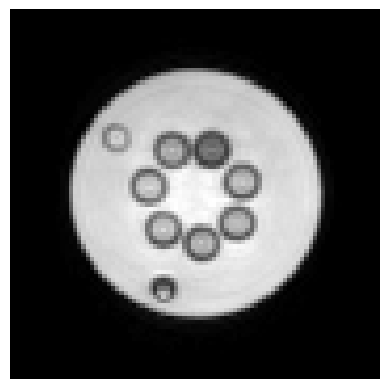

In [5]:
data_fn = 'dataToMatch_30_126_88_slice75.mat'
data_fn = os.path.join(data_f, data_fn)
img = sio.loadmat(data_fn)['dataToMatch']
img = np.nan_to_num(img)[:,19:-19,:]

plt.imshow(img[0,...], cmap='gray')
plt.axis("off")
print("Acquired data shape: "+ str(img.shape))


In [6]:
dictionary['sig'] = np.array(dictionary['sig'])
for key in dictionary.keys():
    if key != 'sig':
        dictionary[key] = np.expand_dims(np.squeeze(np.array(dictionary[key])), 0)
print("After reshaping the acquired data array shape is: " + str(dictionary['sig'].shape))

After reshaping the acquired data array shape is: (273790, 30)


# Dot product matching

In [7]:
# Run dot product matching
start = time.perf_counter()
quant_maps = dot_prod_matching(dictionary=dictionary, acquired_data=img, batch_size=img.shape[1]*2)
end = time.perf_counter()
s = (end - start)
print(f"Dot product matching took {s:.03f} s.")

out_fn = 'quant_maps_3T.mat'
out_fn = os.path.join(output_f, out_fn)
sio.savemat(out_fn, quant_maps)


Dot product matching took 7.711 s.


In [8]:
# Reloading the data as a demonstration for later usage
out_fn = 'quant_maps_3T.mat'
out_fn = os.path.join(output_f, out_fn)
quant_maps = sio.loadmat(out_fn)

In [9]:
# mask from dot-prod
mask_dp = quant_maps['dp'] > 0.9995
np.save('mask_dp.npy', mask_dp)

# mask from ksw
mask_ksw = quant_maps['ksw'] > 100
np.save('mask_ksw_3T.npy', mask_ksw)

# mask from fs
mask_fs = quant_maps['fs'] * 110e3 / 3 > 10
np.save('mask_fs_3T.npy', mask_fs)

mask = mask_ksw * mask_dp * mask_fs

np.save('mask_3T.npy', mask)

# Print results

Resulting plots saved as EPS


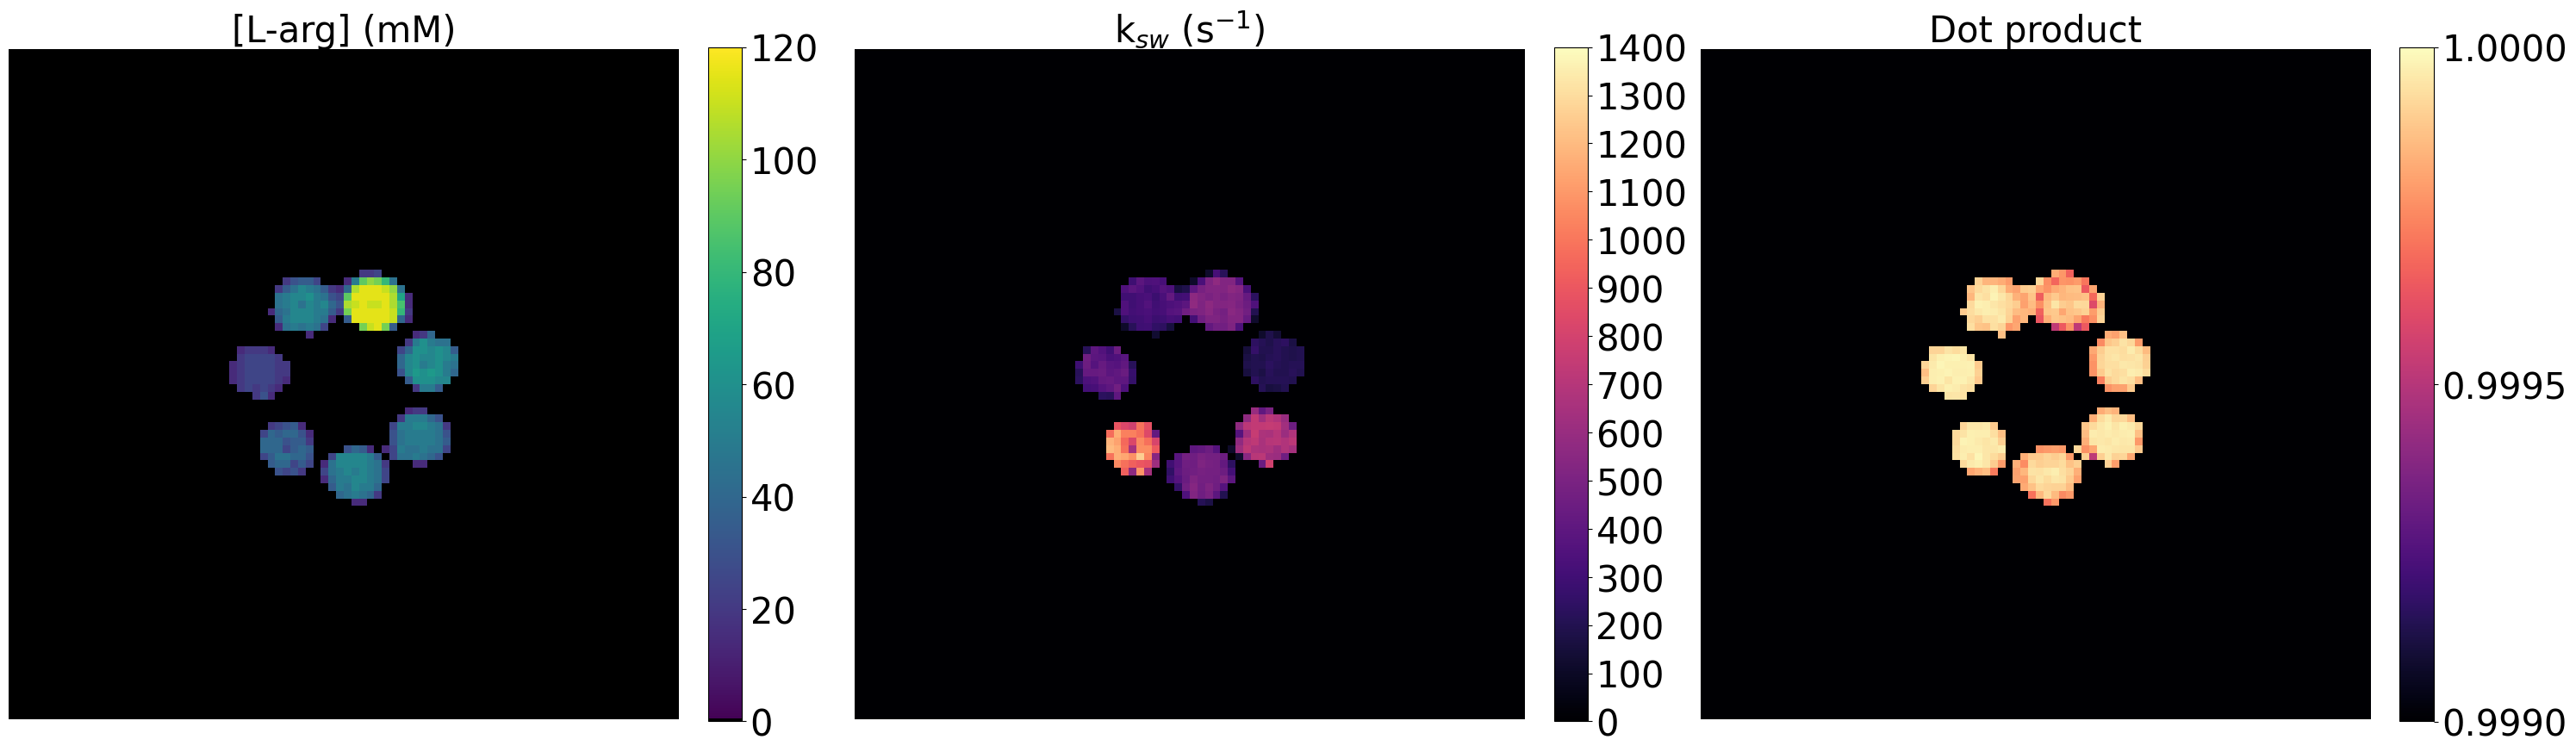

In [12]:
fig_fn = os.path.join(output_f, 'dot_product_results_3T.eps')

os.makedirs(output_f, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(30, 25))

color_maps = [b_viridis, 'magma', 'magma']
data_keys = ['fs', 'ksw', 'dp']
titles = ['[L-arg] (mM)', 'k$_{sw}$ (s$^{-1}$)', 'Dot product']
clim_list = [(0, 120), (0, 1400), (0.999, 1)]
tick_list = [np.arange(0, 140, 20), np.arange(0, 1500, 100), np.arange(0.999, 1.0005, 0.0005)]

unified_font_size = 30

# Save the plot to a PDF file
for ax, color_map, key, title, clim, ticks in zip(axes.flat, color_maps, data_keys, titles, clim_list, tick_list):
    vals = quant_maps[key]

    if key == 'fs':
        vals = vals * 110e3/3

    plot = ax.imshow(vals * mask, cmap=color_map)
    plot.set_clim(*clim)
    ax.set_title(title, fontsize=unified_font_size)
    cb = plt.colorbar(plot, ax=ax, ticks=ticks, orientation='vertical', fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=unified_font_size)
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(fig_fn, format="eps")
print("Resulting plots saved as EPS")